In [480]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, preprocessing

Read the data from spambase.data file, downloaded from UCI data set website. Print out first 6 rows.

In [481]:
df = pd.read_csv('spambase.data', sep = ',', header = None)
df.columns = ["word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", "word_freq_our", "word_freq_over", "word_freq_remove", "word_freq_internet", "word_freq_order", "word_freq_mail", "word_freq_receive", "word_freq_will", "word_freq_people", "word_freq_report", "word_freq_addresses", "word_freq_free", "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit", "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", "word_freq_hp", "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", "word_freq_labs", "word_freq_telnet", "word_freq_857", "word_freq_data", "word_freq_415", "word_freq_85", "word_freq_technology", "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct", "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project", "word_freq_re", "word_freq_edu", "word_freq_table", "word_freq_conference", "char_freq_;", "char_freq_(", "char_freq_[", "char_freq_!", "char_freq_$", "char_freq_#", "capital_run_length_average", "capital_run_length_longest", "capital_run_length_total", "spam"]
print(df.head(6))
df.shape

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   
5            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   
5           1.85            0.00              0.00                1.85  

(4601, 58)

# 1. Using classic Naive Bayes Spam Filter

Importing Multinomial model naive bayes spam filter.

In [482]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

Divide data into two parts, 3500 train data and 1101 test data.

In [483]:
data = np.array(df.iloc[0:,:58])
np.random.shuffle(data)
nTrain = 3500
nTest = 1101
dataTrain = data[0:nTrain, :]
dataTest = data[nTrain+1:nTrain+nTest, :]

For naive bayes spam filter, it only uses the frequency of each word shown up in the email content. So we only use first 54 columns as our Xtrain. 

In [484]:
Xtrain = dataTrain[:, 0:54]
ytrain = dataTrain[:, 57]
Xtest = dataTest[:, 0:54]
ytest = dataTest[:, 57]

Fit in the data and predict it by Xtest.

In [485]:
model.fit(Xtrain, ytrain)
ypredicted = model.predict(Xtest)

Here is the accuracy of prediction.

In [486]:
acci = np.mean(ypredicted == ytest)
acci

0.88090909090909086

# 2. logistic regression

Because the output(spam for 1, not spam for 0) is incontinous, we use logistic regression model to find the relationship between input and output.

In [487]:
Xtrain = dataTrain[:, 0:57]
Xtest = dataTest[:, 0:57]
regr = linear_model.LogisticRegression(C=77)
regr.fit(Xtrain, ytrain)
ypred = regr.predict(Xtrain)
RSStr = np.mean(((ypred-ytrain)**2)/(np.std(ytrain)**2))
ytestpred = regr.predict(Xtest)
RSSte = np.mean(((ytestpred-ytest)**2)/(np.std(ytest)**2))
print("RSS for training is %f and RSS for testing is %f"%(RSStr,RSSte))
acc = np.mean(ytestpred == ytest)
print("Accuracy on training data = %f" % acc)

RSS for training is 0.284426 and RSS for testing is 0.362212
Accuracy on training data = 0.911818


After logistic regression using a random parameter C=77,we get RSS which looks a little bit large.

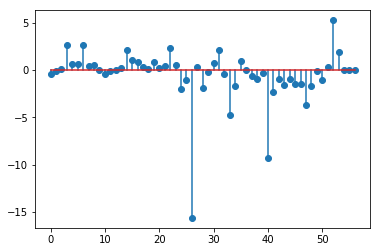

In [488]:
m=np.squeeze(regr.coef_)
plt.stem(m)
plt.show()

The stem diagram shows that there are almost all coeffients that have a influence on the output. Therefore, next we will get rid of the coeffients that nearly have no influence on the output.

# 3. Using Ligistic model with cross validation

In [489]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate=np.zeros(nfold)
x = data[:,0:57]
y=data[:,57]
for ifold, Ind in enumerate(kf.split(x)):   
    Itr,Its=Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    regr.fit(Xtr, ytr)
    yhat = regr.predict(Xts)
    err_rate[ifold]=np.mean(yhat!=yts)
error_mean=np.mean(err_rate)
error_se=np.std(err_rate)/np.sqrt(nfold-1)
print('Accuracy on the test data is  =  {0:.4f}'.format(1-error_mean))

Accuracy on the test data is  =  0.9276


It is obvious that the error rate decreases dramatically after 10 kfold cross validation.

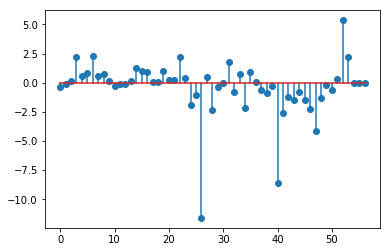

In [490]:
logreg = linear_model.LogisticRegression(C=77)
logreg.fit(x, y)
m=logreg.coef_
plt.stem(m[0,:])
plt.show()

Use kfold cross validation to find the optimal C:

In [491]:
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
err_rate=np.zeros((20,nfold))
C_test=np.logspace(-1,3,20)
logreg = linear_model.LogisticRegression(penalty='l1',warm_start=True)

for ifold, Ind in enumerate(kf.split(x)):   
    Itr,Its=Ind
    Xtr = x[Itr,:]
    ytr = y[Itr]
    Xts = x[Its,:]
    yts = y[Its]
    for ipen,c in enumerate(C_test):
        logreg.C=c
        logreg.fit(Xtr, ytr)
        yhat = logreg.predict(Xts)
        err_rate[ipen,ifold]=np.mean(yhat!=yts)

In [492]:
error_mean=np.mean(err_rate,axis=1)
error_se=np.std(err_rate,axis=1)/np.sqrt(nfold-1)
plt.errorbar(np.log10(C_test),error_mean,marker='o',yerr=error_se)
imin=np.argmin(error_mean)
print("The minimum error rate is %f and SE is %f"%(error_mean[imin],error_se[imin]))

The minimum error rate is 0.073027 and SE is 0.003652


In [493]:
err = error_mean[imin] + error_se[imin]
iopt = np.where(error_mean < err)[0][0]
C_opt = C_test[iopt]
print("The selected model order is {0:f}".format(C_opt))

The selected model order is 0.162378


Use the optimal C and we get the the best coeffients diagram.

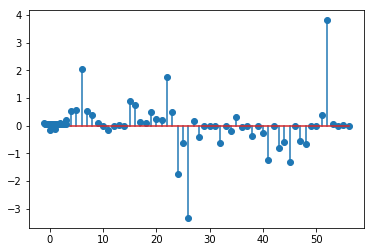

In [494]:
logreg = linear_model.LogisticRegression(C=C_opt,penalty='l1')
logreg.fit(x, y)
W_l1=logreg.coef_
plt.stem(W_l1[0,:])
plt.show()

# 4. Using Neural Network

Import all the package we need.

In [495]:
import keras

In [496]:
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

Clear session.

In [497]:
keras.backend.clear_session()

In [498]:
nh = 20
nout = 1
input_shape = (57,)
model = Sequential()
model.add(Dense(nh, input_shape=input_shape,activation='sigmoid',name='hidden'))
model.add(Dense(nout,activation='sigmoid',name='output'))

In [499]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 20)                1160      
_________________________________________________________________
output (Dense)               (None, 1)                 21        
Total params: 1,181
Trainable params: 1,181
Non-trainable params: 0
_________________________________________________________________


In [500]:
Xstrain = dataTrain[:, 0:57]
Xstest = dataTest[:, 0:57]

Compile the model. Select the correct loss function, optimizer and metrics.

In [501]:
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(Xstrain, ytrain, epochs=100, batch_size=100, validation_data=(Xstest,ytest))

Train on 3500 samples, validate on 1100 samples
Epoch 1/100
3500/3500 [==============================] - 0s - loss: 0.6629 - acc: 0.6023 - val_loss: 0.6210 - val_acc: 0.6791
Epoch 2/100
3500/3500 [==============================] - 0s - loss: 0.6044 - acc: 0.6723 - val_loss: 0.5894 - val_acc: 0.6700
Epoch 3/100
3500/3500 [==============================] - 0s - loss: 0.5739 - acc: 0.6774 - val_loss: 0.5649 - val_acc: 0.6809
Epoch 4/100
3500/3500 [==============================] - 0s - loss: 0.5477 - acc: 0.6874 - val_loss: 0.5352 - val_acc: 0.6945
Epoch 5/100
3500/3500 [==============================] - 0s - loss: 0.5183 - acc: 0.7074 - val_loss: 0.5041 - val_acc: 0.7200
Epoch 6/100
3500/3500 [==============================] - 0s - loss: 0.4816 - acc: 0.7731 - val_loss: 0.4724 - val_acc: 0.7836
Epoch 7/100
3500/3500 [==============================] - 0s - loss: 0.4428 - acc: 0.8094 - val_loss: 0.4327 - val_acc: 0.8073
Epoch 8/100
3500/3500 [==============================] - 0s - loss: 0.

3500/3500 [==============================] - 0s - loss: 0.1552 - acc: 0.9451 - val_loss: 0.1792 - val_acc: 0.9309
Epoch 66/100
3500/3500 [==============================] - 0s - loss: 0.1531 - acc: 0.9460 - val_loss: 0.1773 - val_acc: 0.9318
Epoch 67/100
3500/3500 [==============================] - 0s - loss: 0.1537 - acc: 0.9446 - val_loss: 0.1786 - val_acc: 0.9300
Epoch 68/100
3500/3500 [==============================] - 0s - loss: 0.1568 - acc: 0.9440 - val_loss: 0.1790 - val_acc: 0.9327
Epoch 69/100
3500/3500 [==============================] - 0s - loss: 0.1494 - acc: 0.9483 - val_loss: 0.1880 - val_acc: 0.9309
Epoch 70/100
3500/3500 [==============================] - 0s - loss: 0.1508 - acc: 0.9474 - val_loss: 0.1816 - val_acc: 0.9318
Epoch 71/100
3500/3500 [==============================] - 0s - loss: 0.1520 - acc: 0.9454 - val_loss: 0.1754 - val_acc: 0.9309
Epoch 72/100
3500/3500 [==============================] - 0s - loss: 0.1556 - acc: 0.9446 - val_loss: 0.1918 - val_acc: 0.92

Get the predicted result of both train and test data

In [502]:
y_tr_predicted = np.squeeze(model.predict(Xstrain))
RSStrain = np.mean(((y_tr_predicted-ytrain)**2)/(np.std(ytrain)**2))
print("Normalized RSS training = {0:f}".format(RSStrain))
y_ts_predicted = np.squeeze(model.predict(Xstest))
RSStest = np.mean(((y_ts_predicted-ytest)**2)/(np.std(ytest)**2))
print("Normalized RSS test = {0:f}".format(RSStest))

Normalized RSS training = 0.157740
Normalized RSS test = 0.198617


Since the result from the prediction of model is of format float, we have to convert it to binary number. We set the threshold of 0.5, and value greater than 0.5 can be seen as 1.

In [503]:
for i in range(len(y_tr_predicted)):
    if y_tr_predicted[i] > 0.5:
        y_tr_predicted[i] = 1
    else :
        y_tr_predicted[i] = 0
for i in range(len(y_ts_predicted)):
    if y_ts_predicted[i] > 0.5:
        y_ts_predicted[i] = 1
    else :
        y_ts_predicted[i] = 0
acctrain = np.mean(y_tr_predicted == ytrain)
acctest = np.mean(y_ts_predicted == ytest)
print("Accuracy of train set data is {0:f}".format(acctrain))
print("Accuracy of test set data is {0:f}".format(acctest))

Accuracy of train set data is 0.952571
Accuracy of test set data is 0.939091


Take arbitratry 100 examples, scatter the true value and predicted value, from the graph below, blue spot means correctly matched, red spot means wrong prediction.

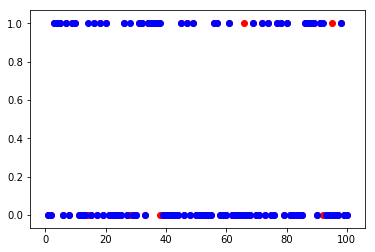

In [504]:
xaxis = np.linspace(1,100,100)
plt.scatter(xaxis, ytest[200:300], color = 'r')
plt.scatter(xaxis, y_ts_predicted[200:300], color = 'b')
plt.show()